# Chapter 7. 回帰分析の悩みどころ

[stanutil.py](https://gist.github.com/arosh/8871c22030cdebab6bebada3f3741bfc) を予めダウンロードしておく。

下記が使えるようになる。
```
def stanfit_to_dataframe(fit, pars=None): fitをDataFrameに変換する
def errorplot(data, x, y, error_low, error_high, hue=None): エラーバー付きプロット
def traceplot(fit, par, inc_warmup=False):　traceplot
def stan_cache(model_code, dirname='stan_cache'): モデルのcache
def MAP(fit, par): MAP推定
def parse_advi(fit, par_regex=None):　よくわからない
```

In [65]:
import pandas as pd
import numpy as np
import pystan
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import stanutil

## 7.2 対数をとるか否か

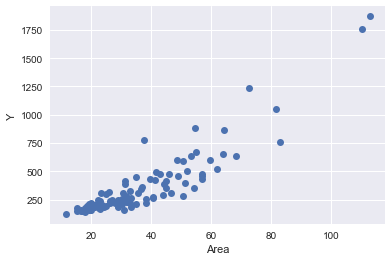

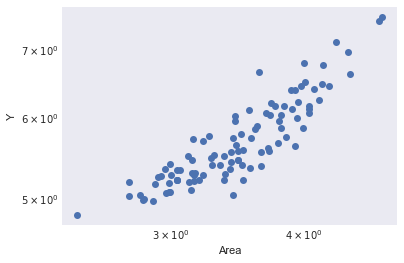

In [13]:
df_1 = pd.read_csv('input/data-rental.txt')
data_1 = df_1.to_dict('list')
data_1['N'] = len(df_1)
data_1['Area_new'] = np.linspace(5, 120, 115)
data_1['N_new'] = len(data_1['Area_new'])
plt.plot(df_1['Area'], df_1['Y'], "o")
plt.xlabel('Area')
plt.ylabel('Y')
plt.show()
plt.plot(df_1['Area'].apply(np.log), df_1['Y'].apply(np.log), "o")
plt.xlabel('Area')
plt.ylabel('Y')
plt.xscale('log')
plt.yscale('log')
plt.show()

最初に変数変換しない場合

In [14]:
model_1 = """
data {
  int N;
  int N_new;
  real<lower=0> Area[N];
  real<lower=0> Area_new[N_new];
  real<lower=0> Y[N];
}

parameters {
  real b1;
  real b2;
  real<lower=0> sigma;
}

transformed parameters {
  real mu[N];
  for (n in 1:N)
    mu[n] = b1 + b2*Area[n];
}

model {
  for (n in 1:N)
    Y[n] ~ normal(mu[n], sigma);
}

generated quantities {
  real y_pred[N];
  real e[N];
  real Y_new[N_new];
  for (n in 1:N) {
    y_pred[n] = normal_rng(mu[n], sigma);
    e[n] = Y[n] - mu[n];
  }
  for (n in 1:N_new)
    Y_new[n] = normal_rng(b1 + b2*Area_new[n], sigma);
}
"""

In [15]:
fit_1 = pystan.stan(model_code=model_1, data=data_1, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_dffa785f8bf96733d0810edf7784b90c NOW.


In [16]:
print(fit_1)

Inference for Stan model: anon_model_dffa785f8bf96733d0810edf7784b90c.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b1         -147.6    1.16  29.43 -204.3 -167.6 -148.6 -127.5 -89.77    642   1.01
b2          13.98    0.03   0.72  12.58   13.5  13.98  14.47  15.45    773   1.01
sigma      131.31    0.29   9.72 113.63  124.6 130.64 137.22 151.35   1129    1.0
mu[0]      420.94     0.3  13.49 393.96 412.26 420.68  429.4 448.47   2000    1.0
mu[1]      718.54    0.62  22.48 674.32 703.48 717.99 734.07 764.64   1303    1.0
mu[2]      623.31    0.48  18.73 586.64 610.63 622.66 636.05 661.02   1542    1.0
mu[3]      646.94    0.51  19.62 608.65 633.63 646.29 660.15  686.3   1469    1.0
mu[4]      646.94    0.51  19.62 608.65 633.63 646.29 660.15  686.3   1469    1.0
mu[5]       69.08    0.77  20.09  31.08  55.35  67.93   82.4 109.18    682 

予測分布を書く関数

In [17]:
def plot_pred_range(fit, xs, ys_key, percentiles, alpha):
    ys = (fit.extract(permuted=True))[ys_key].T
    plt.fill_between( \
        xs, \
        [np.percentile(y, percentiles[0]) for y in ys], \
        [np.percentile(y, percentiles[1]) for y in ys], alpha=alpha)

予測分布

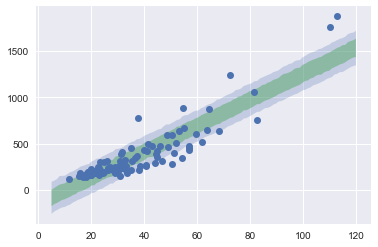

In [18]:
plt.plot(data_1['Area'], data_1['Y'], "o")
plot_pred_range(fit_1, data_1['Area_new'], 'Y_new', (10, 90), 0.25)
plot_pred_range(fit_1, data_1['Area_new'], 'Y_new', (25, 75), 0.5)
plt.show()

誤差のヒストグラム

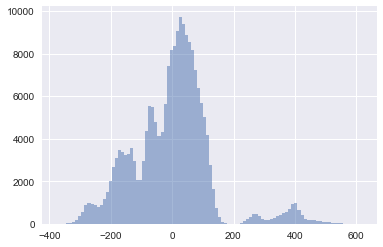

In [19]:
def hist_error(fit):
    plt.hist((fit.extract(permuted=True))['e'].flatten(), bins=100, alpha=0.5);
hist_error(fit_1)

変数変換する場合

In [20]:
model_1a = """
data {
  int N;
  int N_new;
  real<lower=0> Area[N];
  real<lower=0> Area_new[N_new];
  real<lower=0> Y[N];
}

parameters {
  real b1;
  real b2;
  real<lower=0> sigma;
}

transformed parameters {
  real mu[N];
  for (n in 1:N)
    mu[n] = b1 + b2*log(Area[n]);
}

model {
  for (n in 1:N)
    log(Y[n]) ~ normal(mu[n], sigma);
}

generated quantities {
  real y_pred[N];
  real e[N];
  real Y_new[N_new];
  for (n in 1:N) {
    y_pred[n] = exp(normal_rng(mu[n], sigma));
    e[n] = log(Y[n]) - mu[n];
  }
  for (n in 1:N_new)
    Y_new[n] = exp(normal_rng(b1 + b2*log(Area_new[n]), sigma));
}
"""

In [21]:
fit_1a = pystan.stan(model_code=model_1a, data=data_1, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_782ff4b375e8941d35cf9a11725ee848 NOW.


In [22]:
print(fit_1a)

Inference for Stan model: anon_model_782ff4b375e8941d35cf9a11725ee848.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b1           1.83  7.6e-3   0.19   1.45    1.7   1.84   1.96    2.2    649    1.0
b2           1.11  2.1e-3   0.05    1.0   1.07   1.11   1.15   1.22    653    1.0
sigma        0.26  5.9e-4   0.02   0.22   0.24   0.26   0.27   0.29    914   1.01
mu[0]        5.95  6.4e-4   0.03   5.89   5.93   5.94   5.96    6.0   1806    1.0
mu[1]        6.41  1.4e-3   0.04   6.33   6.38   6.41   6.44    6.5    914    1.0
mu[2]        6.28  1.2e-3   0.04   6.21   6.26   6.28   6.31   6.36   1008    1.0
mu[3]        6.32  1.2e-3   0.04   6.24   6.29   6.32   6.34    6.4    980    1.0
mu[4]        6.32  1.2e-3   0.04   6.24   6.29   6.32   6.34    6.4    980    1.0
mu[5]        4.87  1.8e-3   0.05   4.78   4.84   4.87   4.91   4.97    737 

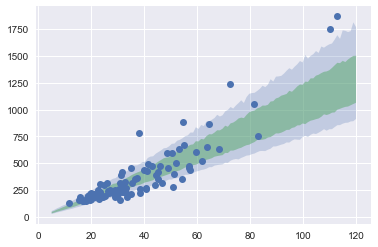

In [23]:
plt.plot(data_1['Area'], data_1['Y'], "o")
plot_pred_range(fit_1a, data_1['Area_new'], 'Y_new', (10, 90), 0.25)
plot_pred_range(fit_1a, data_1['Area_new'], 'Y_new', (25, 75), 0.5)
plt.show()

誤差分布は多少左右対称に近づいたと言える。

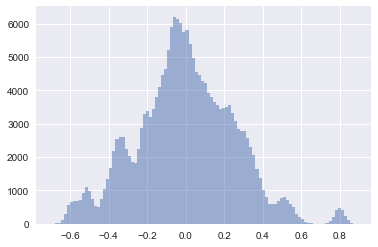

In [24]:
hist_error(fit_1a)

## 7.3 非線形の関係

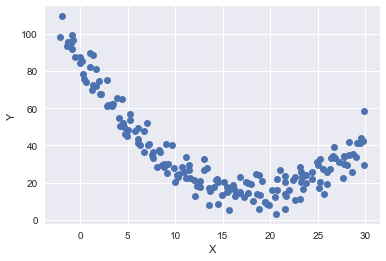

In [25]:
df_2 = pd.read_csv('input/data-aircon.txt')
data_2 = df_2.to_dict('list')
data_2['N'] = len(df_2)
data_2['X_new'] = np.linspace(-5, 35, 40)
data_2['N_new'] = len(data_2['X_new'])
plt.plot(df_2['X'], df_2['Y'], "o")
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [26]:
model_2 = """
data {
  int N;
  real X[N];
  real Y[N];
  int N_new;
  real X_new[N_new];
}

parameters {
  real a;
  real <lower=0> b;
  real <lower=0, upper=30> x0;
  real <lower=0> s_Y;
}

model {
  for (n in 1:N)
    Y[n] ~ normal(a+b*(X[n]-x0)^2, s_Y);
}

generated quantities {
  real y_new[N_new];
  real e[N];
  for (n in 1:N)
    e[n] = Y[n] - (a+b*(X[n]-x0)^2);
  for (n in 1:N_new)
    y_new[n] = normal_rng(a+b*(X_new[n]-x0)^2, s_Y);
}
"""

In [27]:
fit_2 = pystan.stan(model_code=model_2, data=data_2, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_66bddfdc9eac3be7a917ee560c420b40 NOW.


In [28]:
print(fit_2)

Inference for Stan model: anon_model_66bddfdc9eac3be7a917ee560c420b40.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a          14.15    0.02   0.59   13.0  13.74  14.14  14.57  15.24   1375    1.0
b           0.21  1.6e-4 5.5e-3    0.2   0.21   0.21   0.22   0.23   1144    1.0
x0         18.27  4.2e-3   0.15  17.99  18.16  18.26  18.37  18.57   1287    1.0
s_Y         5.74  7.3e-3   0.29   5.18   5.54   5.72   5.91   6.38   1577    1.0
y_new[0]  130.31    0.13   5.86 119.16  126.1 130.19 134.43 141.83   2000    1.0
y_new[1]  120.47    0.13   5.94 108.47 116.46 120.43 124.55 132.11   2000    1.0
y_new[2]  110.72    0.13   5.87  99.03 106.79 110.83 114.49 122.32   2000    1.0
y_new[3]  101.79    0.13   5.85  90.39  97.81 101.69 105.78 113.18   2000    1.0
y_new[4]   93.09    0.14   5.72  82.14  89.43  93.17  96.81 104.51   1730    1.0
y_n

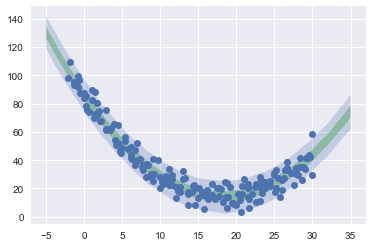

In [29]:
plt.plot(data_2['X'], data_2['Y'], "o")
plot_pred_range(fit_2, data_2['X_new'], 'y_new', (2.5, 97.5), 0.25)
plot_pred_range(fit_2, data_2['X_new'], 'y_new', (25, 75), 0.5)
plt.show()

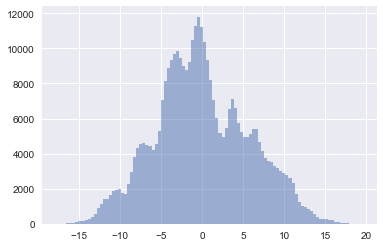

In [30]:
hist_error(fit_2)

In [31]:
df_3 = pd.read_csv('input/data-conc.txt')
df_3

,Time,Y
0,1,2.4
1,2,5.0
2,4,7.5
3,8,11.9
4,12,12.5
5,24,12.7


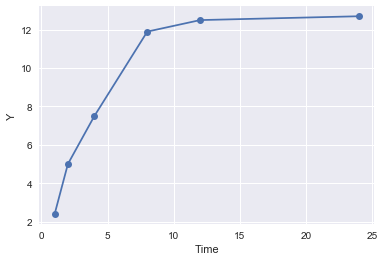

In [32]:
data_3 = df_3.to_dict('list')
data_3['T'] = len(df_3)
data_3['Time_new'] = [np.power(10,x)*24 for x in np.linspace(-2, 0, 40)]
data_3['T_new'] = len(data_3['Time_new'])
plt.plot(df_3['Time'], df_3['Y'], "o-")
plt.xlabel('Time')
plt.ylabel('Y')
#plt.xscale('log')
plt.show()

In [33]:
model_3 = """
data {
  int T;
  real Time[T];
  real Y[T];
  int T_new;
  real Time_new[T_new];
}

parameters {
  real<lower=0, upper=100> a;
  real<lower=0, upper=5> b;
  real<lower=0> s_Y;
}

model {
  for (t in 1:T)
    Y[t] ~ normal(a*(1-exp(-b*Time[t])), s_Y);
}

generated quantities {
  real y_new[T_new];
  for (t in 1:T_new)
    y_new[t] = normal_rng(a*(1-exp(-b*Time_new[t])), s_Y);
}
"""

In [34]:
fit_3 = pystan.stan(model_code=model_3, data=data_3, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_47132d80a244d8a280377ac5bfc34675 NOW.


In [35]:
print(fit_3)

Inference for Stan model: anon_model_47132d80a244d8a280377ac5bfc34675.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a          13.06    0.07   1.09  11.15  12.69  13.09  13.48  14.66    255   1.02
b           0.25  5.9e-3   0.12   0.17   0.22   0.24   0.26   0.37    434   1.01
s_Y         0.94    0.05   0.78   0.37   0.54   0.72   1.04   2.92    217   1.02
y_new[0]    0.78    0.03   1.24  -1.44   0.25   0.73   1.22   3.19   2000    1.0
y_new[1]    0.85    0.03   1.17  -1.17   0.36   0.84   1.33   2.99   2000    1.0
y_new[2]    0.96    0.03   1.19  -1.12   0.42   0.93   1.43   3.48   1951    1.0
y_new[3]    1.03    0.03   1.26  -1.21   0.52   1.03   1.52   3.31   2000    1.0
y_new[4]    1.17    0.03   1.22   -0.9   0.65   1.12   1.65   3.79   1696    1.0
y_new[5]    1.35    0.03   1.22  -0.78   0.83    1.3    1.8   3.93   1307    1.0
y_n

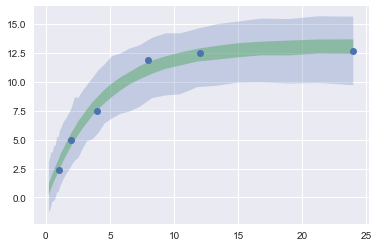

In [36]:
plt.plot(data_3['Time'], data_3['Y'], "o")
plot_pred_range(fit_3, data_3['Time_new'], 'y_new', (2.5, 97.5), 0.25)
plot_pred_range(fit_3, data_3['Time_new'], 'y_new', (25, 75), 0.5)
#plt.xscale('log')
plt.show()

## 7.5 交絡

In [37]:
df_4 = pd.read_csv('input/data-50m.txt')
df_4.head()

,Y,Weight,Age
0,2.46,16.6,7
1,3.02,21.4,7
2,2.91,24.0,7
3,3.05,13.0,7
4,2.60,21.9,7


年齢を考慮しないと、WeightとYには正の相関がある。

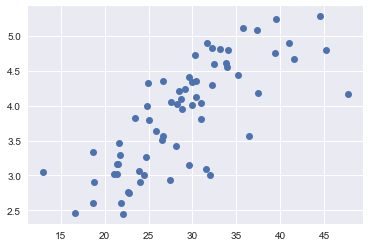

In [38]:
plt.plot(df_4['Weight'], df_4['Y'], "o")

Ageで層別すると、WeightとYには負の相関。

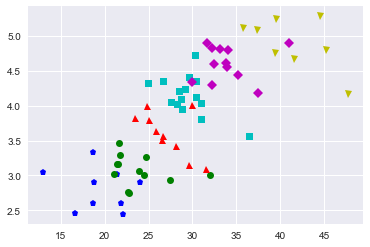

In [39]:
clrs = ['b', 'g', 'r', 'c', 'm', 'y']
syms = ['bp', 'go', 'r^', 'cs', 'mD', 'yv']
for x in range(7, 13):
    df = df_4[df_4['Age'] == x]
    plt.plot(df['Weight'], df['Y'], syms[x-7])
plt.show()

In [40]:
data_4 = df_4.to_dict('list')
data_4['N'] = len(df_4)
data_4['Weight_new'] = np.linspace(10, 50, 40)
data_4['N_new'] = len(data_4['Weight_new'])

In [41]:
model_4 = """
data {
  int N;
  real Weight[N];
  real Y[N];
  int Age[N];
  int N_new;
  real Weight_new[N_new];
}

parameters {
  real c1;
  real c2;
  real<lower=0> sigma_W;
  real b1;
  real b2;
  real b3;
  real<lower=0> sigma_Y;
}

transformed parameters {
  real mu_Weight[N];
  real mu_Y[N];
  for (n in 1:N) {
    mu_Weight[n] = c1 + c2*Age[n];
    mu_Y[n] = b1 + b2*Age[n] + b3*Weight[n];
  }
}

model {
  for (n in 1:N) {
    Weight[n] ~ normal(mu_Weight[n], sigma_W);
    Y[n] ~ normal(mu_Y[n], sigma_Y);
  }
}

generated quantities {
  real y7_new[N_new];
  real y8_new[N_new];
  real y9_new[N_new];
  real y10_new[N_new];
  real y11_new[N_new];
  real y12_new[N_new];
  for (n in 1:N_new) {
    y7_new[n] = normal_rng(b1+b2*7+b3*Weight_new[n], sigma_Y);
    y8_new[n] = normal_rng(b1+b2*8+b3*Weight_new[n], sigma_Y);
    y9_new[n] = normal_rng(b1+b2*9+b3*Weight_new[n], sigma_Y);
    y10_new[n] = normal_rng(b1+b2*10+b3*Weight_new[n], sigma_Y);
    y11_new[n] = normal_rng(b1+b2*11+b3*Weight_new[n], sigma_Y);
    y12_new[n] = normal_rng(b1+b2*12+b3*Weight_new[n], sigma_Y);
  }
}
"""

In [42]:
fit_4 = pystan.stan(model_code=model_4, data=data_4, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5c7ad1414e2e98f8456729f2f6594b40 NOW.


In [43]:
print(fit_4)

Inference for Stan model: anon_model_5c7ad1414e2e98f8456729f2f6594b40.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c1             -8.49    0.07   2.44  -13.5 -10.04   -8.5  -6.88  -3.66   1090    1.0
c2              3.94  7.6e-3   0.25   3.44   3.77   3.94   4.11   4.46   1117    1.0
sigma_W         3.32  7.6e-3   0.31   2.79    3.1    3.3   3.51    4.0   1682    1.0
b1             -0.71  5.8e-3   0.21  -1.12  -0.85  -0.72  -0.57  -0.29   1309    1.0
b2              0.59  1.4e-3   0.04    0.5   0.56   0.59   0.62   0.67   1076    1.0
b3             -0.03  2.9e-4   0.01  -0.06  -0.04  -0.03  -0.03  -0.01   1262    1.0
sigma_Y         0.27  6.4e-4   0.03   0.23   0.25   0.27   0.29   0.33   1546    1.0
mu_Weight[0]   19.11    0.02   0.76  17.61  18.61  19.07  19.59  20.68   1206    1.0
mu_Weight[1]   19.11    0.02   0.76  17.61  18.6

年齢別の50%予測区間を、年齢別に分けたプロットに重ねてみる

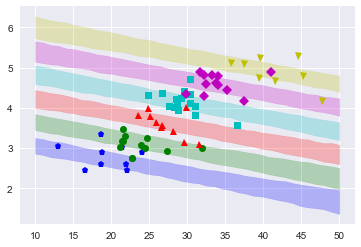

In [44]:
def f_fill(ys_key, c):
    ys = (fit_4.extract(permuted=True))[ys_key].T
    plt.fill_between( \
        data_4['Weight_new'], \
        [np.percentile(y, 25) for y in ys], \
        [np.percentile(y, 75) for y in ys], color=c, alpha=0.25)
for x in range(7, 13):
    df = df_4[df_4['Age'] == x]
    plt.plot(df['Weight'], df['Y'], syms[x-7])
f_fill('y7_new', clrs[0])
f_fill('y8_new', clrs[1])
f_fill('y9_new', clrs[2])
f_fill('y10_new', clrs[3])
f_fill('y11_new', clrs[4])
f_fill('y12_new', clrs[5])
plt.show()

## 7.7 説明変数にノイズを含む

In [45]:
df_5 = pd.read_csv('../Chap04/input/data-salary.txt')
df_5.head()

,X,Y
0,24,472
1,24,403
2,26,454
3,32,575
4,33,546


In [46]:
data_5 = df_5.to_dict('list')
data_5['N'] = len(df_5)

In [47]:
model_5 = """
data {
  int N;
  real X[N];
  real Y[N];
}

parameters {
  real a;
  real b;
  real x_true[N];
  real<lower=0> s_Y;
}

model {
  for (n in 1:N) {
    X[n] ~ normal(x_true[n], 2.5);
    Y[n] ~ normal(a + b*x_true[n], s_Y);
  }
}
"""

In [48]:
fit_5 = pystan.stan(model_code=model_5, data=data_5, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_18e207b9d7765370c2018955b5d65f95 NOW.


In [49]:
print(fit_5)

Inference for Stan model: anon_model_18e207b9d7765370c2018955b5d65f95.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a          -125.7    2.75   72.2 -269.8 -173.9 -122.7 -76.81   8.91    690    1.0
b           22.01    0.06   1.61  18.97  20.92  21.99  23.08  25.21    746    1.0
x_true[0]   25.54    0.05   2.06   21.4  24.18  25.62  27.01  29.38   2000    1.0
x_true[1]   24.06    0.04   1.94  20.22  22.72  24.06  25.39  27.73   2000    1.0
x_true[2]   26.17    0.04   1.92  22.41  24.88  26.17  27.46  29.93   2000    1.0
x_true[3]   31.92    0.04    1.9  28.19   30.7  31.94  33.21  35.73   2000    1.0
x_true[4]   31.87    0.04   1.89  28.27  30.63  31.83  33.11  35.68   2000    1.0
x_true[5]   37.93    0.08   2.16  33.48  36.49  38.05  39.44  41.86    814    1.0
x_true[6]   38.87    0.04   1.82  35.26   37.7   38.9  40.09  42.34   2000 

## 7.8 打ち切り

In [50]:
df_6 = pd.read_csv('input/data-protein.txt')
data_6 = df_6.to_dict('list')
df_6

,Y
0,<25
1,32.3
2,<25
3,28.3
4,30.8
5,35.2


In [51]:
data_6['Y_obs'] = [float(y) for y in data_6['Y'] if not y.startswith('<')]
data_6['N_obs'] = len(data_6['Y_obs'])
data_6['N_cens'] = len([y for y in data_6['Y'] if y.startswith('<')])
data_6['L'] = 25
del data_6['Y']

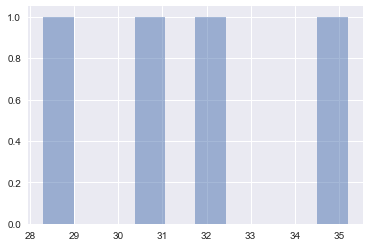

In [52]:
plt.hist(data_6['Y_obs'], bins=10, alpha=0.5);

In [53]:
model_6 = """
data {
  int N_obs;
  int N_cens;
  real Y_obs[N_obs];
  real L;
}

parameters {
  real mu;
  real<lower=0> s_Y;
}

model {
  for (n in 1:N_obs)
    Y_obs[n] ~ normal(mu, s_Y);
  target += N_cens * normal_lcdf(L | mu, s_Y);
}
"""

In [54]:
fit_6 = pystan.stan(model_code=model_6, data=data_6, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a91441ec8e91a4096d633b0c21623918 NOW.


In [55]:
print(fit_6)

Inference for Stan model: anon_model_a91441ec8e91a4096d633b0c21623918.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu    12.53   14.28  99.97 -124.0  23.23  27.12  29.68  39.33     49   1.09
s_Y   30.82   16.69 115.61   3.95   6.77  10.05  16.45 220.12     48   1.09
lp__ -10.56    0.38   2.29 -18.73 -10.91  -9.84  -9.23  -8.84     37   1.12

Samples were drawn using NUTS at Wed Apr 19 15:47:13 2017.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


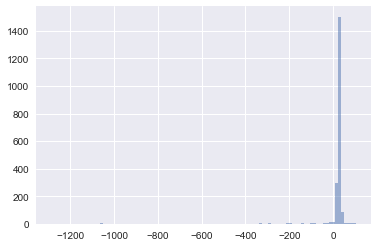

In [56]:
plt.hist((fit_6.extract(permuted=True))['mu'], bins=100, alpha=0.5);

## 7.9 外れ値

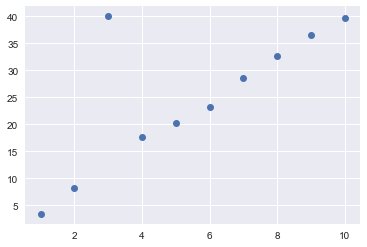

In [57]:
df_7 = pd.read_csv('input/data-outlier.txt')
data_7 = df_7.to_dict('list')
plt.plot(data_7['X'], data_7['Y'], 'o')

最初に正規分布でやってみる

In [58]:
data_7['N'] = len(data_7['X'])
data_7['X_new'] = np.linspace(0, 11, 55)
data_7['N_new'] = len(data_7['X_new'])

In [59]:
model_7a = """
data {
  int N;
  real X[N];
  real Y[N];
  int N_new;
  real X_new[N_new];
}

parameters {
  real a;
  real b;
  real<lower=0> sigma;
}

model {
  for (n in 1:N)
    Y[n] ~ normal(a + b*X[n], sigma);
}

generated quantities {
  real y_new[N_new];
  for (n in 1:N_new)
    y_new[n] = normal_rng(a + b*X_new[n], sigma);
}
"""

In [60]:
fit_7a = pystan.stan(model_code=model_7a, data=data_7, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9b5686156e474a8f9f0c50009b840a66 NOW.


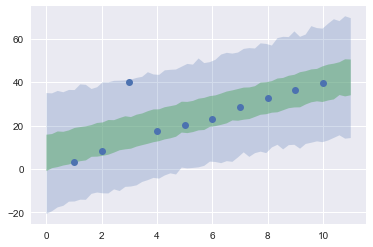

In [61]:
plt.plot(data_7['X'], data_7['Y'], "o")
plot_pred_range(fit_7a, data_7['X_new'], 'y_new', (2.5, 97.5), 0.25)
plot_pred_range(fit_7a, data_7['X_new'], 'y_new', (25, 75), 0.5)
plt.show()

In [62]:
model_7 = """
data {
  int N;
  real X[N];
  real Y[N];
  int N_new;
  real X_new[N_new];
}

parameters {
  real a;
  real b;
  real<lower=0> sigma;
}

model {
  for (n in 1:N)
    Y[n] ~ cauchy(a + b*X[n], sigma);
}

generated quantities {
  real y_new[N_new];
  for (n in 1:N_new)
    y_new[n] = cauchy_rng(a + b*X_new[n], sigma);
}
"""

In [63]:
fit_7 = pystan.stan(model_code=model_7, data=data_7, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e31ca1e60d9a92a263f448ad8763fb24 NOW.


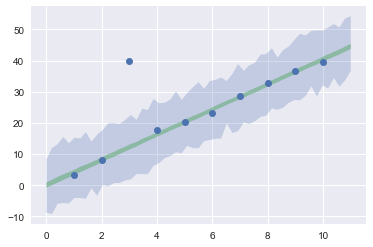

In [64]:
plt.plot(data_7['X'], data_7['Y'], "o")
plot_pred_range(fit_7, data_7['X_new'], 'y_new', (2.5, 97.5), 0.25)
plot_pred_range(fit_7, data_7['X_new'], 'y_new', (25, 75), 0.5)
plt.show()